# Exploring Wikipedia clickstream data: the English Wiki in December 2018    

## Exploratory Data Analysis

### 1. Introduction  
This notebook contains EDA of the English Wikipedia clickstream dataset for December 2018. It is a part of my project about the usage patterns of Wikipedia across language domains and over time.  

The Wikipedia clickstream datasets are available for 11 of some of the largest Wikipedia language domains, and can be downloaded [here](https://dumps.wikimedia.org/other/clickstream/). They are released monthly, and each contain one month's worth of aggregated clickstream data. The data is aggregated at the (referer, request)-pair level. The total number of times users went from the referer page to the request page is given as the clickstream traffic volume between the two pages.  

To start off my Wikipedia clickstream exploration project, I've decided to first look at the most recent clickstream data for the largest Wikipedia domain. The English Wikipedia is the oldest and largest of all Wikipedia language domains, and, not surprisingly, the one with the most usage. And at this time, the most recent English Wikipedia clickstream dataset available is for December 2018, and can be downloaded [here](https://dumps.wikimedia.org/other/clickstream/2018-12/). So, I'm starting off here by analyzing the English Wikipedia clickstream data for December 2018.    

The goals of this EDA is to take a look at the basic stats of this dataset, the distributions the data follows, and any outliers and data anomalies. I will then use these insights to model the data as a graph for conducting network analysis in the next notebook for this project.


### 2. Notebook setup  
The code needed to set up this notebook for running the analysis below. It contains imports, custom settings, helper functions, data read-in, etc.

#### Imports

In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [25]:
from IPython.display import display

#### Settings

In [132]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [133]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

#### Helper functions

In [143]:
def plot_freq_on_log_log_scale(value_counts_series, title):
    my_alpha = 0.25
    plt.scatter(value_counts_series.index.values, value_counts_series.values, c="b", alpha=my_alpha)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('Traffic volume')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.title(title);

In [129]:
def aggregate_edges_by(df, categorical_var):
    edges_count = df.groupby(categorical_var).n.count()
    edges_count.rename("edges_count", inplace=True)
    traffic_volume = df.groupby(categorical_var).n.sum()
    traffic_volume.rename("traffic_volume", inplace=True)

    agg_df = pd.concat([edges_count, traffic_volume], axis=1)
    agg_df["edges_count_pct"] = agg_df["edges_count"] / agg_df["edges_count"].sum()
    agg_df["traffic_volume_pct"] = agg_df["traffic_volume"] / agg_df["traffic_volume"].sum()
    agg_df["traffic_avg"] = agg_df["traffic_volume"]/agg_df["edges_count"]

    return agg_df

#### Read in, clean and check the data

In [4]:
# Read the cleaned up EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12_clean.tsv"
df = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])

In [5]:
# Replace the false missing value NaNs with string "NaN"s
df['prev'] = df['prev'].fillna('NaN')
df['curr'] = df['curr'].fillna('NaN')

In [7]:
df.sort_values("n", ascending=False, inplace=True)

### 3. Analysis

#### Overall data
First, let's take a look at the overall clickstream dataset. 

In [6]:
df.describe(include='all')

,prev,curr,type,n
count,29847736,29847736,29847736,29847736.00
unique,1714260,5183771,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5093433,127578,17851574,nan
mean,NaN,NaN,NaN,230.46
std,NaN,NaN,NaN,90303.30
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,28.00
75%,NaN,NaN,NaN,71.00


In [207]:
df.head(10)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
772288,other-external,Hyphen-minus,external,17676430
765759,other-empty,Hyphen-minus,external,15498618
7831692,other-internal,Main_Page,external,8826536
21252458,other-search,George_H._W._Bush,external,4576854
3488262,other-empty,XHamster,external,4281194
23951757,other-search,Jason_Momoa,external,3538068
18403529,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671


In [9]:
edge_traffic_frequencies = df.n.value_counts()

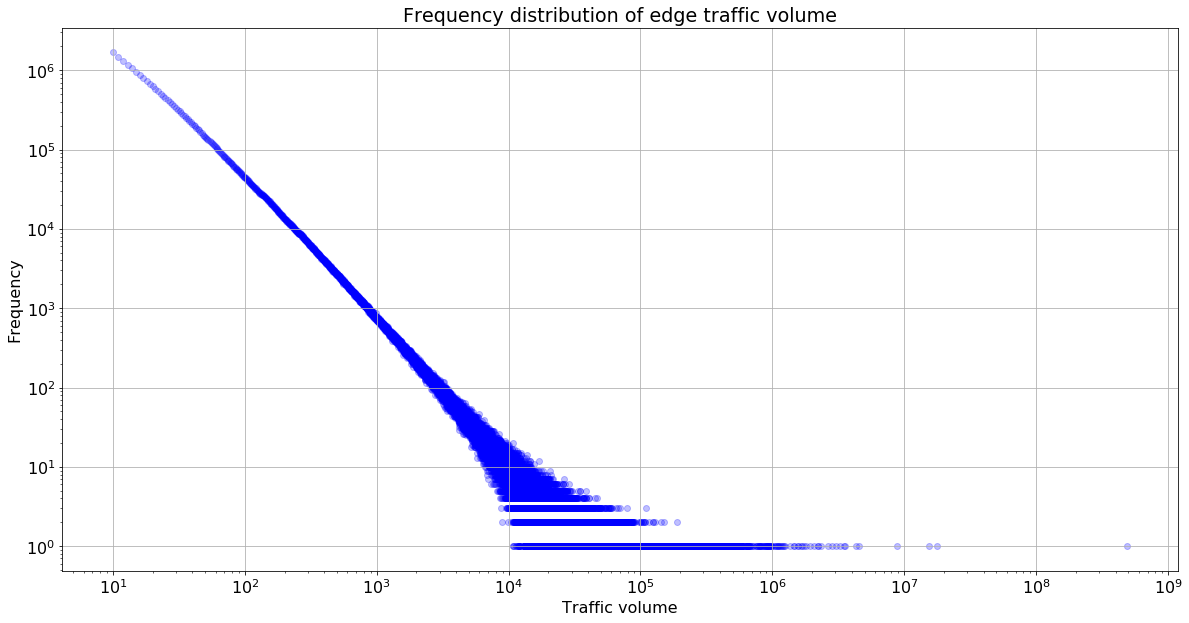

In [144]:
plot_freq_on_log_log_scale(edge_traffic_frequencies, "Frequency distribution of edge traffic volume")

There are 29,847,736 (referer, reference) pairs in this dataset. We'll call these pairs **edges**.  

From the descriptive statistics output and the log-log frequency plot above, we can see that the edge traffic volume values do not follow a normal distribution, and the mean and standard deviation are not particularly meaningful here. Instead, the edge traffic volume distribution looks close to a straight line on the log-log frequency plot for lower traffic volume values, and then fans out towards the tail of the distribution with the very high traffic volumes.  
The straight line on the log-log plot suggests a Pareto-like distribution, and it is a necessary but not sufficient evidence of a power law relationship ([source](https://en.wikipedia.org/wiki/Power_law#Graphical_methods_for_identification)). 

This distribution shape tells us that there are lots of edges with small amount of traffic, and very few edges with very large amounts of traffic. This is indicative of a [preferential attachment process](https://en.wikipedia.org/wiki/Preferential_attachment) underlying the data, which in this case is that Wikipedia users tend to follow popular clickstream paths. With the exception of a few possible outliers with extremely high traffic volume, the distribution is as expected.

---

#### Splitting the data by reference type  

Based on DQA, the overall dataset should be split up by reference type, because external references are aggregated into general categories of referers, while link and internal search references are pairs of Wikipedia article pages. 

The Wikipedia clickstream dataset is a collection of referer-requested webpage pairs (edges) with aggregated traffic count for the pair within the given month. These edges are of 3 types in the data: **external**, **link** and **other**. The external type means that the referer webpage is some webpage outside of the English Wikipedia. The **link** and **other** reference types are both for edges connecting Wikipedia articles. The **link** type means that the user followed a link from one Wikipedia article to another. And the **other** type means that the user went from one Wikipedia article to another, but there was no link between them. This happens if the user gets to the second article by searching from the first article, or if the referer is spoofed.

Here's the distribution of traffic volume and edge counts across the 3 reference types.

In [134]:
summary_by_type = aggregate_edges_by(df, "type")
summary_by_type

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
type,,,,,
external,10990982,5100299091,0.37,0.74,464.04
link,17851574,1718399222,0.60,0.25,96.26
other,1005180,60022438,0.03,0.01,59.71


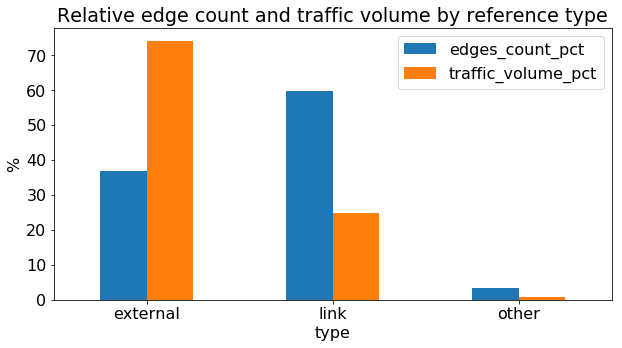

In [12]:
ax = plt.gca()
(summary_by_type[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary_by_type.index)), summary_by_type.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by reference type")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(10,5);

74% of all traffic volume on the English Wikipedia during December 2018 consists of users going from an external website, search, or app, or having an empty referer, and visiting a page on the English Wikipedia. A quarter of the traffic volume is users following links within the Wikipedia from one article to another. And the remaining 1% of the traffic volume is likely from users visiting Wikipedia articles after searching from within the Wikipedia.  

The bar chart above shows a surprisingly low edges count for reference type=external. This is in part due to the aggregation of external referers into general categories, vs. the 'link' and 'other' reference types having individual webpages for referers.  

Let's look at the edge traffic distributions for each reference type.

In [13]:
external_edges = df[df.type == 'external']
link_edges = df[df.type == 'link']
other_edges = df[df.type == 'other']

In [14]:
external_edges_traffic_frequencies = external_edges.n.value_counts()
link_edges_traffic_frequencies = link_edges.n.value_counts()
other_edges_traffic_frequencies = other_edges.n.value_counts()

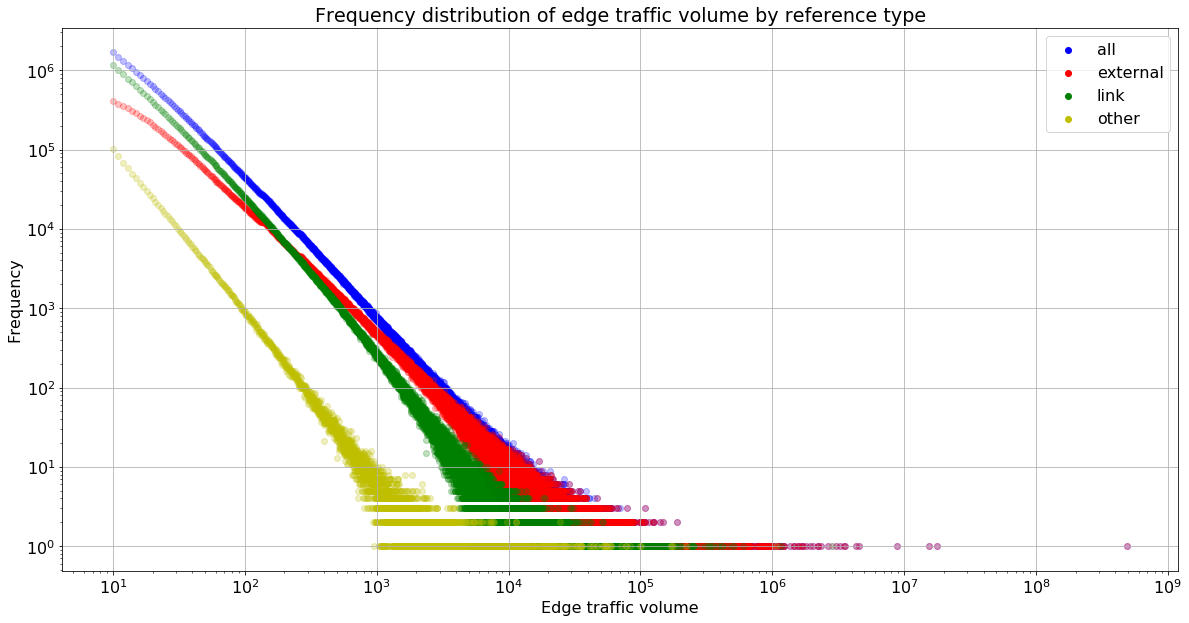

In [15]:
my_alpha = 0.25
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", label="all", alpha=my_alpha)
plt.scatter(external_edges_traffic_frequencies.index.values, external_edges_traffic_frequencies.values, \
            c="r", label="external", alpha=my_alpha)
plt.scatter(link_edges_traffic_frequencies.index.values, link_edges_traffic_frequencies.values, \
            c="g", label="link", alpha=my_alpha)
plt.scatter(other_edges_traffic_frequencies.index.values, other_edges_traffic_frequencies.values, \
            c="y", label="other", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)


plt.title("Frequency distribution of edge traffic volume by reference type");

The above plot shows a couple of interesting things. It shows that the majority of edges with extremely high traffic volume have external referers. It also shows that the external reference type distribution has a different slope from the other two. The 'link' and 'other' reference type distributions seem to have a very similar slope and shape.

#### EXTERNAL reference type  
The external reference type means that the referer is not an article from the English Wikipedia.  

The exact external referer webpages/etc are not specified in the data, and are instead aggregated into 5 categories (as decribed [here](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Data_Preparation)):  
- **other-external**: External website referers, i.e. the user went from some external website to a Wikipedia article page.  
- **other-search**: External search referers, i.e. the user searched for something on a search engine page and from there went to a Wikipedia article page.
- **other-internal**: Referers from some other Wikimedia project. It could be a different language Wikipedia or some other Wikimedia project that is not a Wikipedia.
- **other-empty**: An empty referer. This can be the result of a browser homepage setting, a security measure, a bot, etc.
- **other-other**: Any other external referer.  

In [16]:
external_edges.describe(include='all')

,prev,curr,type,n
count,10990982,10990982,10990982,10990982.00
unique,5,5163109,1,nan
top,other-empty,Red_seabream,external,nan
freq,5093433,5,10990982,nan
mean,NaN,NaN,NaN,464.04
std,NaN,NaN,NaN,148805.73
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,38.00
75%,NaN,NaN,NaN,121.00


In [17]:
external_edges.head(20)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
772288,other-external,Hyphen-minus,external,17676430
765759,other-empty,Hyphen-minus,external,15498618
7831692,other-internal,Main_Page,external,8826536
21252458,other-search,George_H._W._Bush,external,4576854
3488262,other-empty,XHamster,external,4281194
23951757,other-search,Jason_Momoa,external,3538068
18403529,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671


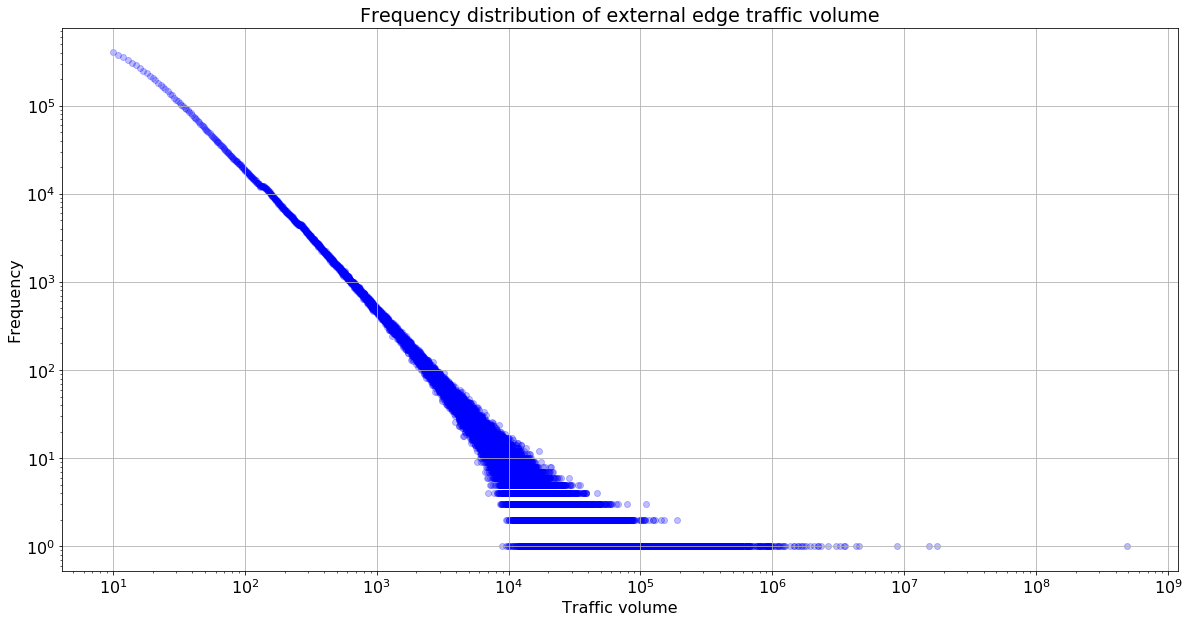

In [145]:
plot_freq_on_log_log_scale(external_edges_traffic_frequencies, 
                           "Frequency distribution of external edge traffic volume")

In [135]:
summary = aggregate_edges_by(external_edges, "prev")
summary

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
other-empty,5093433,1779965188,0.46,0.35,349.46
other-external,787311,116732857,0.07,0.02,148.27
other-internal,1348892,132349844,0.12,0.03,98.12
other-other,374921,36972380,0.03,0.01,98.61
other-search,3386425,3034278822,0.31,0.59,896.01


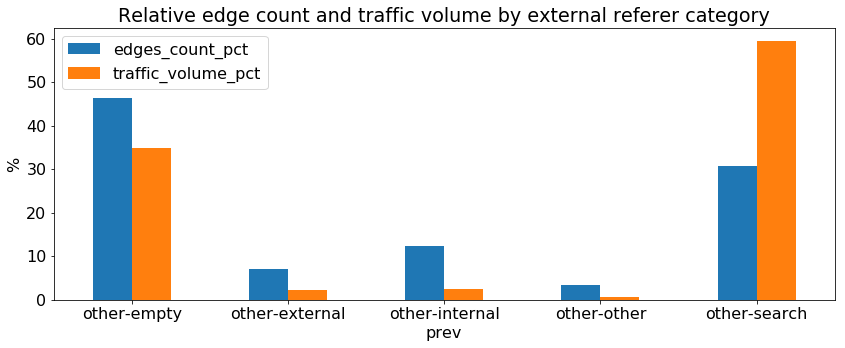

In [20]:
ax = plt.gca()
(summary[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary.index)), summary.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by external referer category")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(14,5);

In [22]:
external_websites_edges = external_edges[external_edges.prev == 'other-external']
external_search_edges = external_edges[external_edges.prev == 'other-search']
other_wikimedia_edges = external_edges[external_edges.prev == 'other-internal']
empty_referer_edges = external_edges[external_edges.prev == 'other-empty']
external_other_edges = external_edges[external_edges.prev == 'other-other']

external_websites_edges.name = "external_websites"
external_search_edges.name = "external_search"
other_wikimedia_edges.name = "other_wikimedia"
empty_referer_edges.name = "empty_referer"
external_other_edges.name = "external_other"

In [23]:
external_edges_freq_dict = {}
external_edges_list = \
    [external_websites_edges, external_search_edges, other_wikimedia_edges, empty_referer_edges, external_other_edges]
for e in external_edges_list:
    external_edges_freq_dict[e.name] = e.n.value_counts()

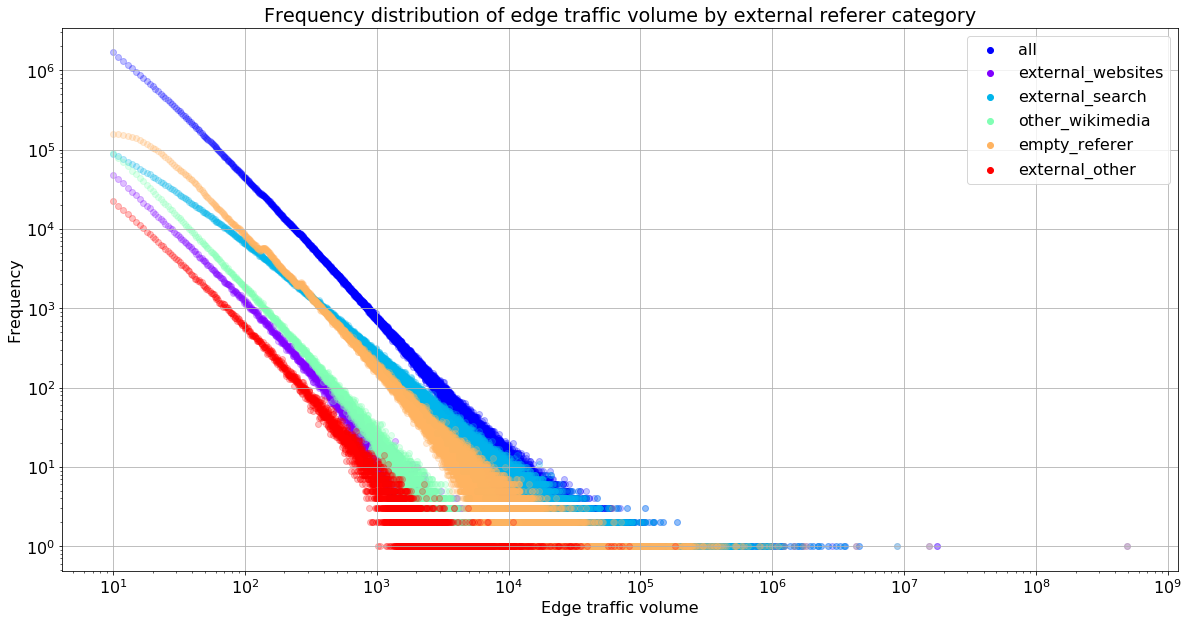

In [24]:
my_alpha = 0.25
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 5))
i = 0
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", label="all", alpha=my_alpha)
for key in external_edges_freq_dict:
    plt.scatter(external_edges_freq_dict[key].index.values, external_edges_freq_dict[key].values, \
            c=[colors[i]], label=key, alpha=my_alpha)
    i+=1
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)

plt.title("Frequency distribution of edge traffic volume by external referer category");

In [26]:
for e in external_edges_list:
    print("External referer category:", e.name)
    print("Descriptive stats")
    display(e.describe(include='all'))
    print("Top 20 observations")
    display(e.head(20))
    print("=====================")

External referer category: external_websites
Descriptive stats


,prev,curr,type,n
count,787311,787311,787311,787311.00
unique,1,787311,1,nan
top,other-external,Paul_Barber_(actor),external,nan
freq,787311,1,787311,nan
mean,NaN,NaN,NaN,148.27
std,NaN,NaN,NaN,19997.55
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,27.00
75%,NaN,NaN,NaN,66.00


Top 20 observations


,prev,curr,type,n
772288,other-external,Hyphen-minus,external,17676430
7911237,other-external,Main_Page,external,677294
17715549,other-external,HTTP_404,external,636210
7013418,other-external,Toilet-related_injuries_and_deaths,external,499771
9345692,other-external,Kotii_Reddy,external,365723
4678252,other-external,Vilnius,external,239233
13233515,other-external,OpenText,external,209113
2365108,other-external,Singapore,external,209027
21826646,other-external,China,external,169522
5577541,other-external,2015_Tianjin_explosions,external,168136


External referer category: external_search
Descriptive stats


,prev,curr,type,n
count,3386425,3386425,3386425,3386425.00
unique,1,3386425,1,nan
top,other-search,Neil_Sang,external,nan
freq,3386425,1,3386425,nan
mean,NaN,NaN,NaN,896.01
std,NaN,NaN,NaN,9169.17
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,24.00
50%,NaN,NaN,NaN,67.00
75%,NaN,NaN,NaN,269.00


Top 20 observations


,prev,curr,type,n
21252458,other-search,George_H._W._Bush,external,4576854
23951757,other-search,Jason_Momoa,external,3538068
18403529,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671
5686277,other-search,Aquaman_(film),external,2634665
25647123,other-search,Bird_Box,external,2328884
4776244,other-search,Priyanka_Chopra,external,2231176
20229173,other-search,List_of_most-disliked_YouTube_videos,external,2226602
20509526,other-search,Freddie_Mercury,external,2050628


External referer category: other_wikimedia
Descriptive stats


,prev,curr,type,n
count,1348892,1348892,1348892,1348892.00
unique,1,1348892,1,nan
top,other-internal,IPCC_Fifth_Assessment_Report,external,nan
freq,1348892,1,1348892,nan
mean,NaN,NaN,NaN,98.12
std,NaN,NaN,NaN,7675.69
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,24.00
75%,NaN,NaN,NaN,57.00


Top 20 observations


,prev,curr,type,n
7831692,other-internal,Main_Page,external,8826536
718456,other-internal,Hyphen-minus,external,1102895
24135220,other-internal,NetScout_Systems,external,164599
5685679,other-internal,Aquaman_(film),external,131946
1830779,other-internal,Bird_Box_(film),external,127234
21252211,other-internal,George_H._W._Bush,external,109536
11460836,other-internal,Alfred_Werner_Maurer,external,99521
2804399,other-internal,Saleem_Dabbour,external,95989
1395045,other-internal,Lists_of_deaths_by_year,external,90288
26953883,other-internal,Spider-Man:_Into_the_Spider-Verse,external,89905


External referer category: empty_referer
Descriptive stats


,prev,curr,type,n
count,5093433,5093433,5093433,5093433.00
unique,1,5093433,1,nan
top,other-empty,Cerithium_rueppelli,external,nan
freq,5093433,1,5093433,nan
mean,NaN,NaN,NaN,349.46
std,NaN,NaN,NaN,218285.52
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,35.00
75%,NaN,NaN,NaN,100.00


Top 20 observations


,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
765759,other-empty,Hyphen-minus,external,15498618
3488262,other-empty,XHamster,external,4281194
17100674,other-empty,Darth_Vader,external,1801074
9889788,other-empty,Segersjön,external,1724261
1395258,other-empty,Lists_of_deaths_by_year,external,1457060
20816436,other-empty,Exo_(band),external,1223507
11283146,other-empty,2018_FIFA_World_Cup,external,1077101
23951884,other-empty,Jason_Momoa,external,990366
6365678,other-empty,Null,external,944711


External referer category: external_other
Descriptive stats


,prev,curr,type,n
count,374921,374921,374921,374921.00
unique,1,374921,1,nan
top,other-other,Bongaigaon_(Vidhan_Sabha_constituency),external,nan
freq,374921,1,374921,nan
mean,NaN,NaN,NaN,98.61
std,NaN,NaN,NaN,582.40
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,27.00
75%,NaN,NaN,NaN,66.00


Top 20 observations


,prev,curr,type,n
18403629,other-other,2.0_(film),external,182358
7864821,other-other,Main_Page,external,81647
62341,other-other,Zero_(2018_film),external,72911
800518,other-other,K.G.F:_Chapter_1,external,68387
11367499,other-other,List_of_highest-grossing_Indian_films,external,63234
1519345,other-other,Sexy_Movie,external,59806
26295856,other-other,XXXX,external,57086
27074482,other-other,List_of_Bollywood_films_of_2018,external,39626
4767645,other-other,Blue_Film_Woman,external,35363
4776132,other-other,Priyanka_Chopra,external,34612


### Link reference type

In [27]:
link_edges.describe(include='all')

,prev,curr,type,n
count,17851574,17851574,17851574,17851574.00
unique,1703705,2598302,1,nan
top,New_York_City,United_States,link,nan
freq,2224,6368,17851574,nan
mean,NaN,NaN,NaN,96.26
std,NaN,NaN,NaN,870.84
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,25.00
75%,NaN,NaN,NaN,56.00


In [28]:
link_edges.head(20)

,prev,curr,type,n
9722110,Jason_Momoa,Lisa_Bonet,link,1166522
6473638,Priyanka_Chopra,Nick_Jonas,link,596798
1830750,Bird_Box,Bird_Box_(film),link,508241
4776073,Nick_Jonas,Priyanka_Chopra,link,493898
23721511,George_H._W._Bush,George_W._Bush,link,453809
6531433,George_H._W._Bush,Pauline_Robinson_Bush,link,419132
18515291,George_H._W._Bush,Barbara_Bush,link,412565
21252092,George_W._Bush,George_H._W._Bush,link,393452
10588026,George_H._W._Bush,Dorothy_Bush_Koch,link,377785
365460,Emily_Atack,Kate_Robbins,link,354577


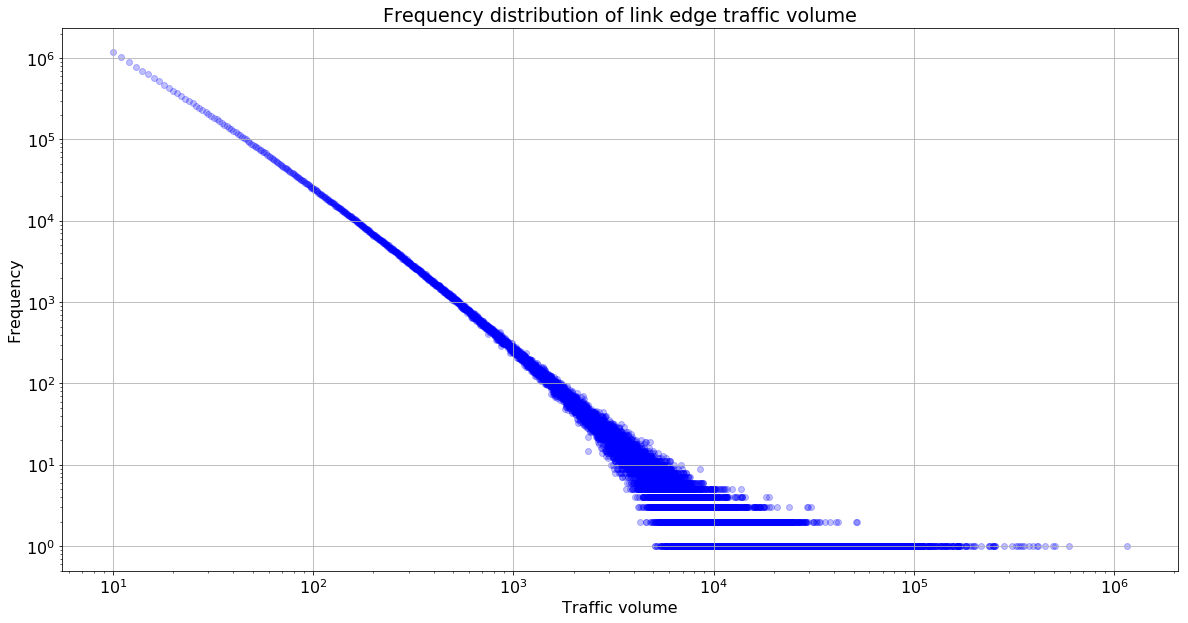

In [146]:
plot_freq_on_log_log_scale(link_edges_traffic_frequencies, 
                           "Frequency distribution of link edge traffic volume")

#### Start nodes

In [147]:
link_start_nodes = aggregate_edges_by(link_edges, "prev")
link_start_nodes.sort_values("traffic_volume", ascending=False, inplace=True)
link_start_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
count,1703705.0000,1703705.0000,1703705.0000,1703705.0000,1703705.0000
mean,10.4781,1008.6249,0.0000,0.0000,41.5321
std,25.8979,9291.2455,0.0000,0.0000,100.8778
min,1.0000,10.0000,0.0000,0.0000,10.0000
25%,1.0000,26.0000,0.0000,0.0000,15.0000
50%,3.0000,86.0000,0.0000,0.0000,23.2727
75%,9.0000,359.0000,0.0000,0.0000,41.5000
max,2224.0000,4466936.0000,0.0001,0.0026,30491.7761


In [148]:
pd.options.display.float_format = '{:.4f}'.format

link_start_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
George_H._W._Bush,811,4466936,0.0000,0.0026,5507.9359
Aquaman_(film),250,2391941,0.0000,0.0014,9567.7640
Jason_Momoa,96,2226611,0.0000,0.0013,23193.8646
Bird_Box_(film),67,2042949,0.0000,0.0012,30491.7761
Spider-Man:_Into_the_Spider-Verse,319,1872733,0.0000,0.0011,5870.6364
Exo_(band),129,1639704,0.0000,0.0010,12710.8837
Macaulay_Culkin,164,1441673,0.0000,0.0008,8790.6890
George_W._Bush,562,1343059,0.0000,0.0008,2389.7847
Priyanka_Chopra,423,1245686,0.0000,0.0007,2944.8842


In [149]:
link_start_nodes_traffic_freq = link_start_nodes.traffic_volume.value_counts()

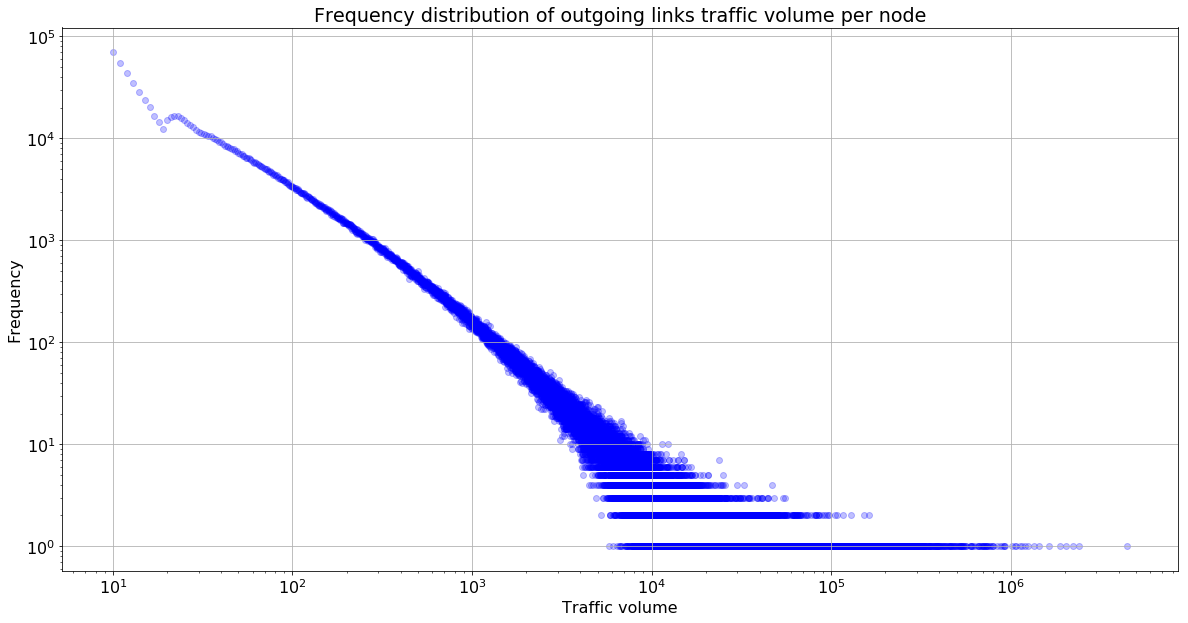

In [153]:
plot_freq_on_log_log_scale(link_start_nodes_traffic_freq, 
                           "Frequency distribution of outgoing links traffic volume per node")

In [151]:
link_start_nodes.sort_values("edges_count", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
New_York_City,2224,196519,0.0001,0.0001,88.3629
London,2061,170028,0.0001,0.0001,82.4978
William_Shakespeare,2043,231056,0.0001,0.0001,113.0964
Russia,2039,225218,0.0001,0.0001,110.4551
California,2039,135372,0.0001,0.0001,66.3914
France,1874,173974,0.0001,0.0001,92.8356
United_States,1815,557659,0.0001,0.0003,307.2501
Paris,1804,106901,0.0001,0.0001,59.2578
Massachusetts,1753,88968,0.0001,0.0001,50.7519


In [152]:
link_start_nodes_edge_counts_freq = link_start_nodes.edges_count.value_counts()

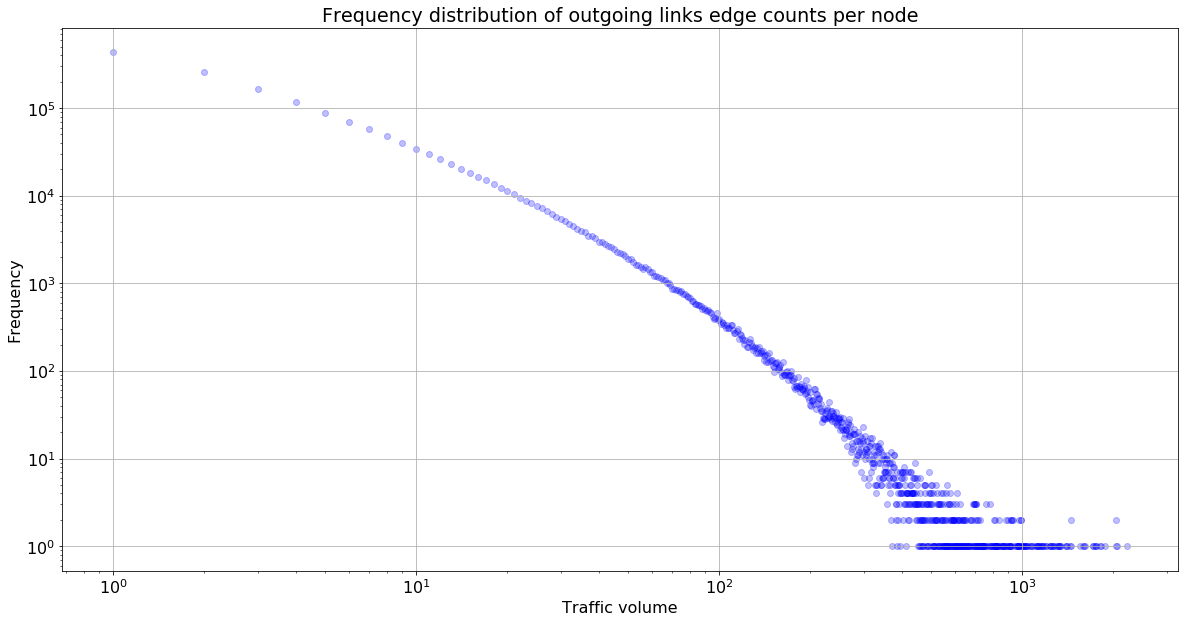

In [154]:
plot_freq_on_log_log_scale(link_start_nodes_edge_counts_freq, 
                           "Frequency distribution of outgoing links edge counts per node")

In [155]:
link_start_nodes.sort_values("traffic_avg", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
Bird_Box_(film),67,2042949,0.0000,0.0012,30491.7761
NetScout_Systems,6,164479,0.0000,0.0001,27413.1667
Bird_Box,30,737163,0.0000,0.0004,24572.1000
Jason_Momoa,96,2226611,0.0000,0.0013,23193.8646
Marwencol,3,64645,0.0000,0.0000,21548.3333
Article_13,2,39465,0.0000,0.0000,19732.5000
Lists_of_people_who_disappeared,9,139415,0.0000,0.0001,15490.5556
Emily_Atack,45,614814,0.0000,0.0004,13662.5333
Exo_(band),129,1639704,0.0000,0.0010,12710.8837


In [199]:
link_start_nodes_traffic_avg_freq = np.floor(link_start_nodes.traffic_avg).value_counts()

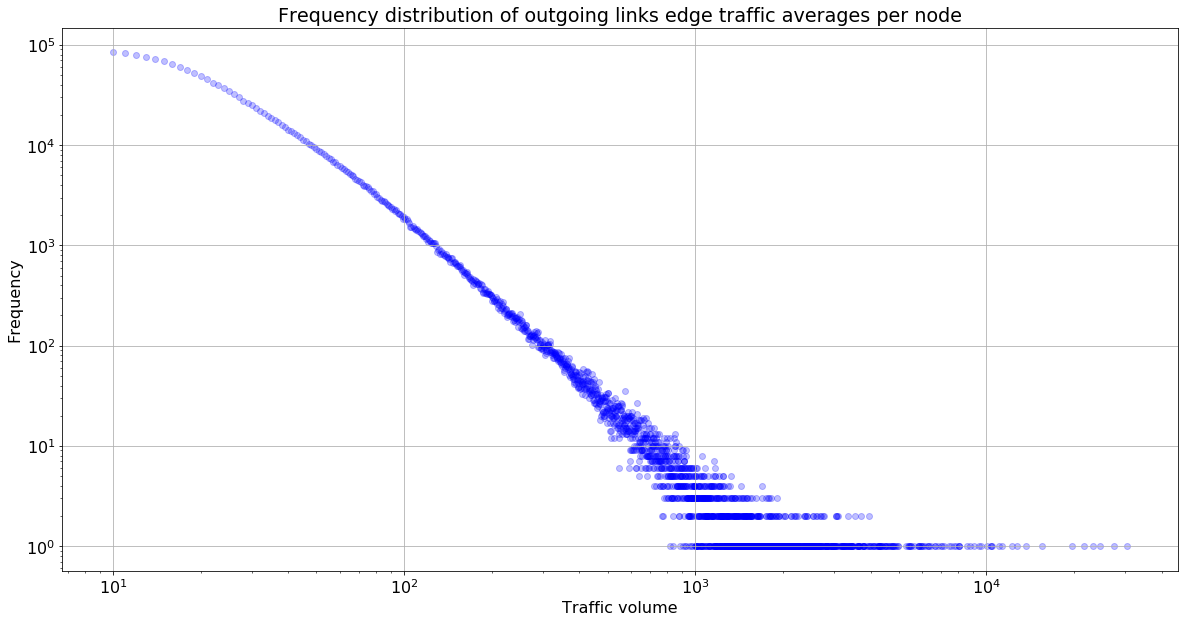

In [200]:
plot_freq_on_log_log_scale(link_start_nodes_traffic_avg_freq, 
                           "Frequency distribution of outgoing links edge traffic averages per node")

#### Top authorities

In [158]:
link_end_nodes = aggregate_edges_by(link_edges, "curr")
link_end_nodes.sort_values("traffic_volume", ascending=False, inplace=True)
link_end_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
count,2598302.0000,2598302.0000,2598302.0000,2598302.0000,2598302.0000
mean,6.8705,661.3547,0.0000,0.0000,65.1580
std,20.7608,4031.2270,0.0000,0.0000,359.7287
min,1.0000,10.0000,0.0000,0.0000,10.0000
25%,1.0000,26.0000,0.0000,0.0000,17.0000
50%,2.0000,79.0000,0.0000,0.0000,29.7000
75%,6.0000,302.0000,0.0000,0.0000,57.2000
max,6368.0000,1217004.0000,0.0004,0.0007,202678.0000


In [159]:
link_end_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
curr,,,,,
Lisa_Bonet,53,1217004,0.0000,0.0007,22962.3396
George_H._W._Bush,956,1108189,0.0001,0.0006,1159.1935
George_W._Bush,1002,907853,0.0001,0.0005,906.0409
Nick_Jonas,152,776311,0.0000,0.0005,5107.3092
Bird_Box_(film),42,682992,0.0000,0.0004,16261.7143
Jason_Momoa,91,639353,0.0000,0.0004,7025.8571
Dorothy_Bush_Koch,34,605207,0.0000,0.0004,17800.2059
Avengers:_Endgame,230,603912,0.0000,0.0004,2625.7043
Zoë_Kravitz,90,598633,0.0000,0.0003,6651.4778


In [160]:
link_end_nodes_traffic_freq = link_end_nodes.traffic_volume.value_counts()

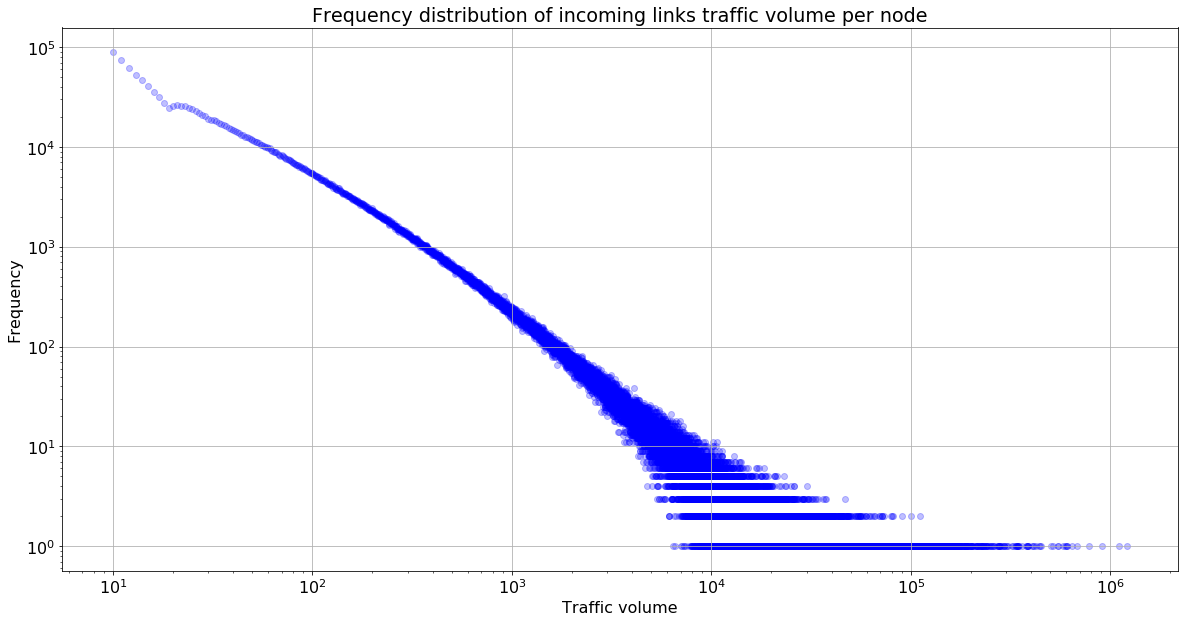

In [161]:
plot_freq_on_log_log_scale(link_end_nodes_traffic_freq, 
                           "Frequency distribution of incoming links traffic volume per node")

In [162]:
link_end_nodes.sort_values("edges_count", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
curr,,,,,
United_States,6368,403347,0.0004,0.0002,63.3397
India,3855,203531,0.0002,0.0001,52.7966
United_Kingdom,3166,228569,0.0002,0.0001,72.1949
World_War_II,2578,145984,0.0001,0.0001,56.6268
New_York_City,2385,143048,0.0001,0.0001,59.9782
YouTube,2375,132473,0.0001,0.0001,55.7781
Los_Angeles,2078,93011,0.0001,0.0001,44.7599
China,2045,129257,0.0001,0.0001,63.2064
IMDb,2032,52762,0.0001,0.0000,25.9656


In [163]:
link_end_nodes_edge_counts_freq = link_end_nodes.edges_count.value_counts()

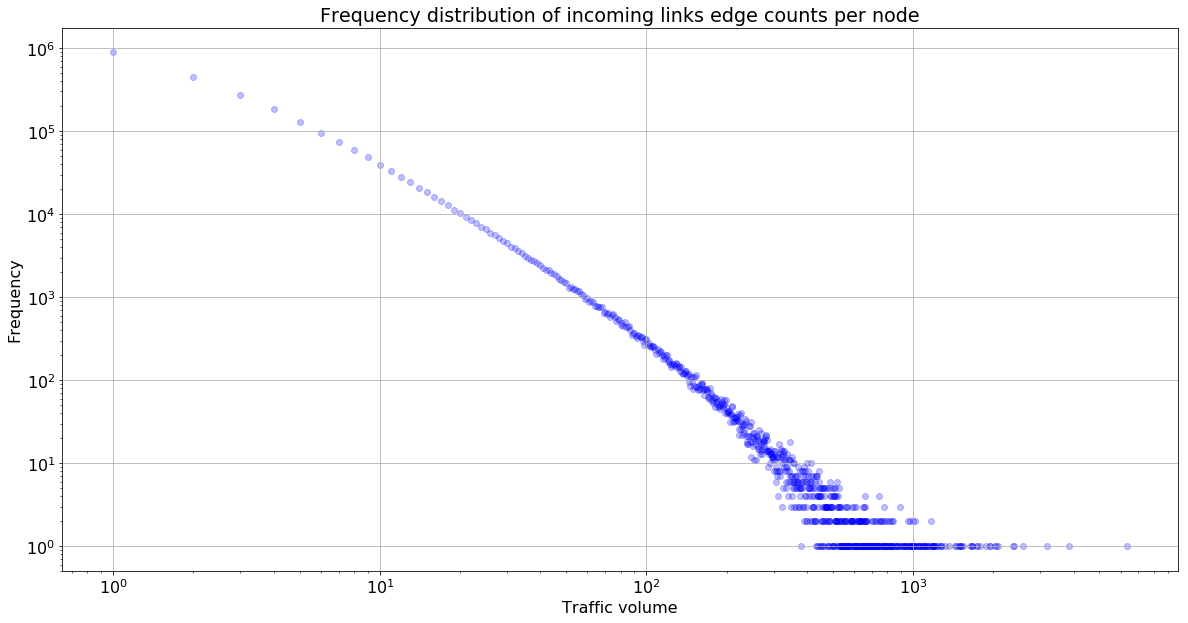

In [164]:
plot_freq_on_log_log_scale(link_end_nodes_edge_counts_freq, 
                           "Frequency distribution of incoming links edge counts per node")

In [165]:
link_end_nodes.sort_values("traffic_avg", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
curr,,,,,
Tasya_van_Ree,1,202678,0.0000,0.0001,202678.0000
List_of_Emily_Blunt_performances,1,119814,0.0000,0.0001,119814.0000
Keanu_Reeves_filmography,1,76607,0.0000,0.0000,76607.0000
List_of_Hugh_Jackman_performances,1,76477,0.0000,0.0000,76477.0000
Akshay_Kumar_filmography,1,76431,0.0000,0.0000,76431.0000
Marwencol_(film),4,299096,0.0000,0.0002,74774.0000
Vijay_Sethupathi_filmography,1,70201,0.0000,0.0000,70201.0000
You_(season_1),1,66623,0.0000,0.0000,66623.0000
Ryan_Reynolds_filmography,1,66521,0.0000,0.0000,66521.0000


In [201]:
link_end_nodes_traffic_avg_freq = np.floor(link_end_nodes.traffic_avg).value_counts()

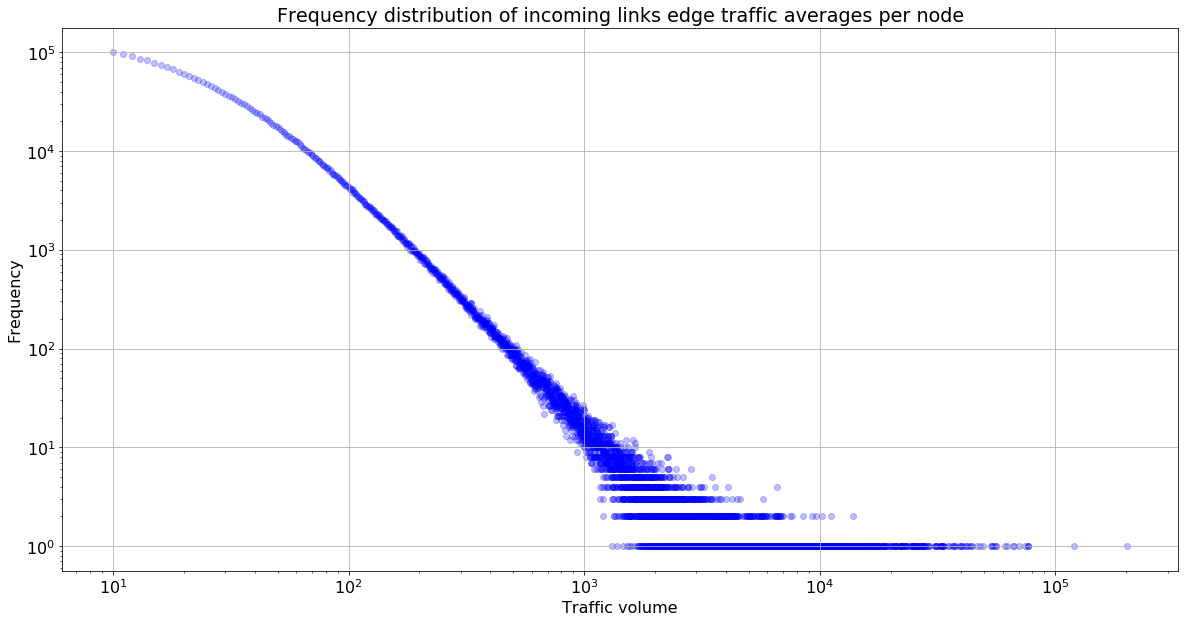

In [202]:
plot_freq_on_log_log_scale(link_end_nodes_traffic_avg_freq, 
                           "Frequency distribution of incoming links edge traffic averages per node")

### Internal search from Wikipedia pages
'Other' reference type

In [78]:
other_edges.describe(include='all')

,prev,curr,type,n
count,1005180,1005180,1005180,1005180.0000
unique,302292,414847,1,nan
top,Main_Page,Hyphen-minus,other,nan
freq,257794,127458,1005180,nan
mean,NaN,NaN,NaN,59.7131
std,NaN,NaN,NaN,3080.4576
min,NaN,NaN,NaN,10.0000
25%,NaN,NaN,NaN,12.0000
50%,NaN,NaN,NaN,18.0000
75%,NaN,NaN,NaN,35.0000


In [79]:
other_edges.head(20)

,prev,curr,type,n
727986,Main_Page,Hyphen-minus,other,2838090
1395264,Main_Page,Lists_of_deaths_by_year,other,1065668
21252593,Main_Page,George_H._W._Bush,other,220667
15997541,Main_Page,Yellow_vests_movement,other,178234
21175288,Main_Page,Balangiga_bells,other,171702
6426095,Main_Page,Pineapple,other,170129
23370493,Main_Page,2018_Sunda_Strait_tsunami,other,100842
28097656,Main_Page,2018_Strasbourg_attack,other,98728
5564468,Main_Page,Voyager_2,other,83172
12932182,Main_Page,OSIRIS-REx,other,78426


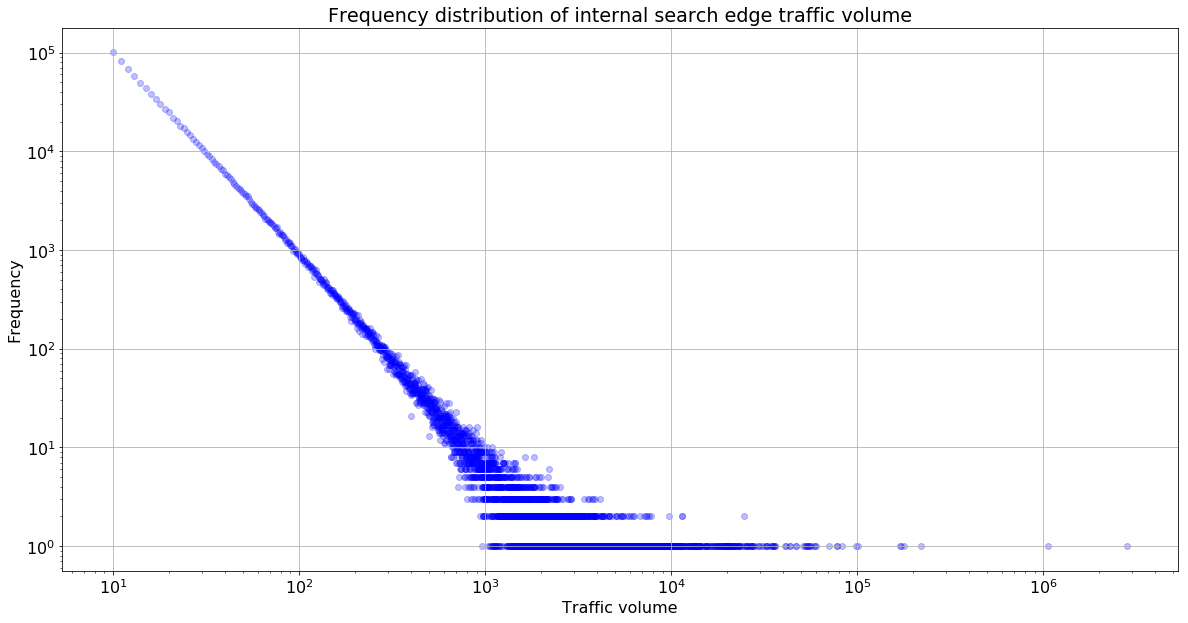

In [168]:
plot_freq_on_log_log_scale(other_edges_traffic_frequencies, 
                           "Frequency distribution of internal search edge traffic volume")

#### Top hubs

In [169]:
other_start_nodes = aggregate_edges_by(other_edges, "prev")
other_start_nodes.sort_values("traffic_volume", ascending=False, inplace=True)
other_start_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
count,302292.0000,302292.0000,302292.0000,302292.0000,302292.0000
mean,3.3252,198.5578,0.0000,0.0000,25.6492
std,468.9605,59069.7268,0.0005,0.0010,97.7297
min,1.0000,10.0000,0.0000,0.0000,10.0000
25%,1.0000,14.0000,0.0000,0.0000,12.5000
50%,1.0000,27.0000,0.0000,0.0000,17.0000
75%,3.0000,66.0000,0.0000,0.0000,27.0000
max,257794.0000,32475706.0000,0.2565,0.5411,40893.0000


In [170]:
other_start_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
Main_Page,257794,32475706,0.2565,0.5411,125.9754
Wiki,3778,138360,0.0038,0.0023,36.6226
Welcome_to_Marwen,109,72643,0.0001,0.0012,666.4495
George_H._W._Bush,377,70544,0.0004,0.0012,187.1194
Ralph_Breaks_the_Internet,212,67236,0.0002,0.0011,317.1509
Wikipedia,1998,59717,0.0020,0.0010,29.8884
Jason_Momoa,183,50044,0.0002,0.0008,273.4645
Aquaman_(film),588,46824,0.0006,0.0008,79.6327
2.0_(film),255,46226,0.0003,0.0008,181.2784


In [171]:
other_start_nodes_traffic_freq = other_start_nodes.traffic_volume.value_counts()

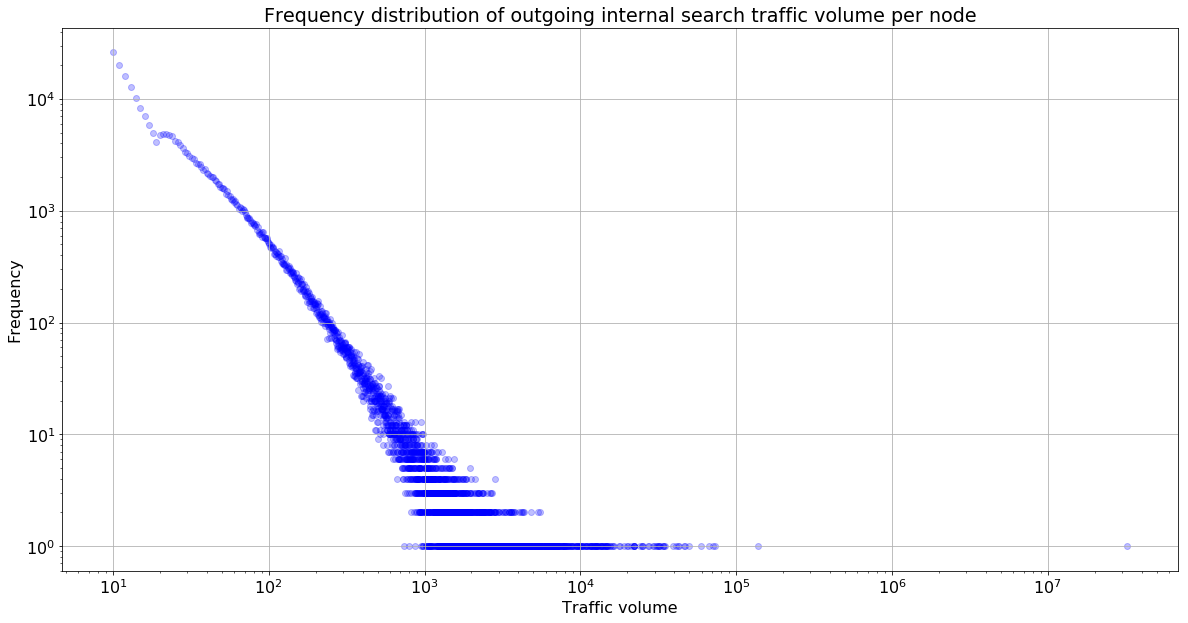

In [172]:
plot_freq_on_log_log_scale(other_start_nodes_traffic_freq, 
                           "Frequency distribution of outgoing internal search traffic volume per node")

In [173]:
other_start_nodes.sort_values("edges_count", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
Main_Page,257794,32475706,0.2565,0.5411,125.9754
Wiki,3778,138360,0.0038,0.0023,36.6226
Wikipedia,1998,59717,0.0020,0.0010,29.8884
Aquaman_(film),588,46824,0.0006,0.0008,79.6327
English_Wikipedia,539,20313,0.0005,0.0003,37.6865
Bird_Box_(film),413,29267,0.0004,0.0005,70.8644
Spider-Man:_Into_the_Spider-Verse,407,31021,0.0004,0.0005,76.2187
2018_in_film,394,13069,0.0004,0.0002,33.1701
George_H._W._Bush,377,70544,0.0004,0.0012,187.1194


In [174]:
other_start_nodes_edge_counts_freq = other_start_nodes.edges_count.value_counts()

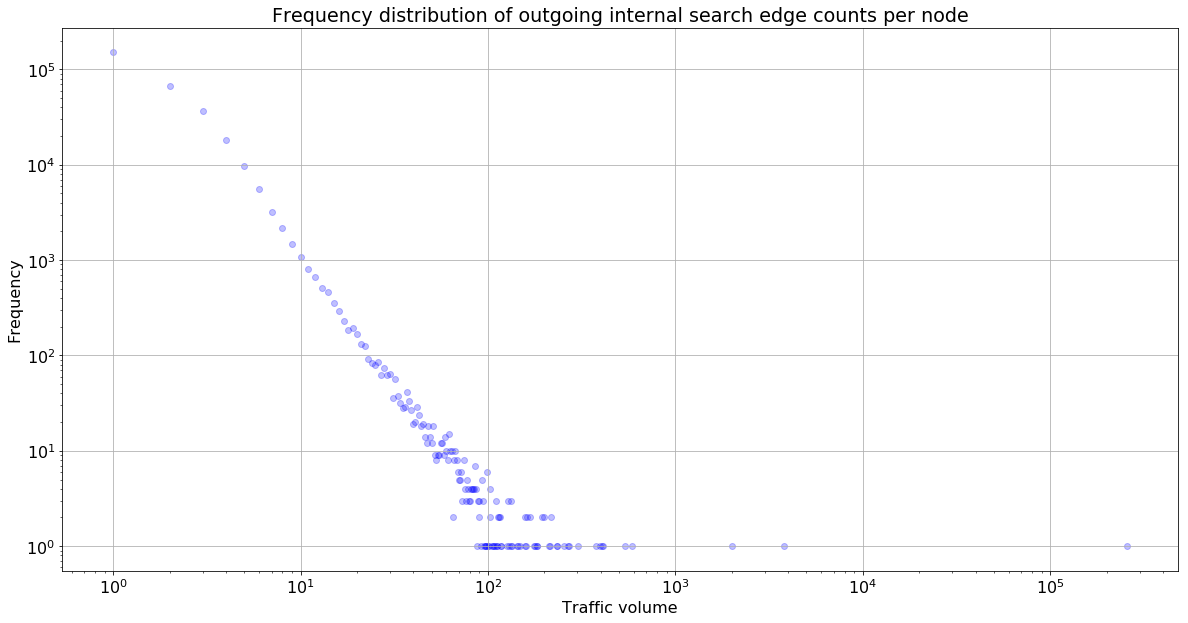

In [175]:
plot_freq_on_log_log_scale(other_start_nodes_edge_counts_freq, 
                           "Frequency distribution of outgoing internal search edge counts per node")

In [176]:
other_start_nodes.sort_values("traffic_avg", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
prev,,,,,
AppNeta,1,40893,0.0000,0.0007,40893.0000
Jock_McKeen,1,27418,0.0000,0.0005,27418.0000
Check_verification_service,2,22147,0.0000,0.0004,11073.5000
Liliana_Mumy,3,8342,0.0000,0.0001,2780.6667
Keisha_Grey,4,9566,0.0000,0.0002,2391.5000
Balaji_Tharaneetharan,3,6542,0.0000,0.0001,2180.6667
2005_in_music,1,2008,0.0000,0.0000,2008.0000
Grimes_(musician),12,21940,0.0000,0.0004,1828.3333
Blue_Film_Woman,8,14373,0.0000,0.0002,1796.6250


In [93]:
other_edges[other_edges.prev == "AppNeta"]

,prev,curr,type,n
7810741,AppNeta,Main_Page,other,40893


In [94]:
other_edges[other_edges.prev == "Jock_McKeen"]

,prev,curr,type,n
1677693,Jock_McKeen,Undefined,other,27418


In [95]:
other_edges[other_edges.prev == "Check_verification_service"]

,prev,curr,type,n
1677749,Check_verification_service,Undefined,other,22087
26078825,Check_verification_service,Cheque_clearing,other,60


In [102]:
other_edges[other_edges.prev == "YouTube_Rewind"]

,prev,curr,type,n
988187,YouTube_Rewind,BetterHelp,other,8709
8500310,YouTube_Rewind,TotalBiscuit,other,7208
2038055,YouTube_Rewind,T-Series_(company),other,6807
24311093,YouTube_Rewind,Stefán_Karl_Stefánsson,other,5787
14000195,YouTube_Rewind,Stephen_Hillenburg,other,3413
5593995,YouTube_Rewind,XXXTentacion,other,2419
18338404,YouTube_Rewind,Mac_Miller,other,2189
11423850,YouTube_Rewind,The_Mind_of_Jake_Paul,other,1656
7226782,YouTube_Rewind,Baby_(Justin_Bieber_song),other,1270
21175400,YouTube_Rewind,Stephen_Hawking,other,1074


In [203]:
other_start_nodes_traffic_avg_freq = np.floor(other_start_nodes.traffic_avg).value_counts()

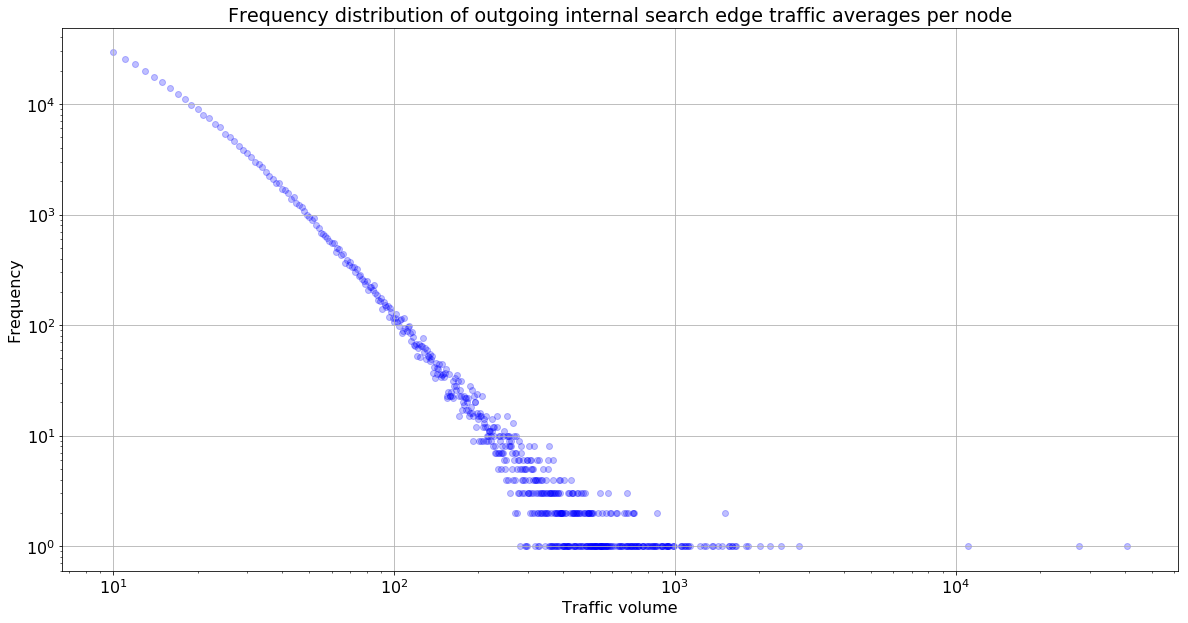

In [204]:
plot_freq_on_log_log_scale(other_start_nodes_traffic_avg_freq, 
                           "Frequency distribution of outgoing internal search edge traffic averages per node")

#### Top authorities

In [181]:
other_end_nodes = aggregate_edges_by(other_edges, "curr")
other_end_nodes.sort_values("traffic_volume", ascending=False, inplace=True)
other_end_nodes.describe()

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
count,414847.0000,414847.0000,414847.0000,414847.0000,414847.0000
mean,2.4230,144.6857,0.0000,0.0000,51.2643
std,261.4296,13425.0331,0.0003,0.0002,476.3243
min,1.0000,10.0000,0.0000,0.0000,10.0000
25%,1.0000,14.0000,0.0000,0.0000,14.0000
50%,1.0000,26.0000,0.0000,0.0000,21.0000
75%,2.0000,64.0000,0.0000,0.0000,39.7071
max,127458.0000,7557718.0000,0.1268,0.1259,85917.5000


In [182]:
other_end_nodes.head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
curr,,,,,
Hyphen-minus,127458,7557718,0.1268,0.1259,59.2958
Main_Page,110009,4013760,0.1094,0.0669,36.4857
Lists_of_deaths_by_year,275,1074677,0.0003,0.0179,3907.9164
George_H._W._Bush,228,226297,0.0002,0.0038,992.5307
Yellow_vests_movement,25,178842,0.0000,0.0030,7153.6800
Balangiga_bells,2,171835,0.0000,0.0029,85917.5000
Pineapple,27,170638,0.0000,0.0028,6319.9259
2018_Sunda_Strait_tsunami,4,100893,0.0000,0.0017,25223.2500
2018_Strasbourg_attack,6,99298,0.0000,0.0017,16549.6667


In [183]:
other_end_nodes_traffic_freq = other_end_nodes.traffic_volume.value_counts()

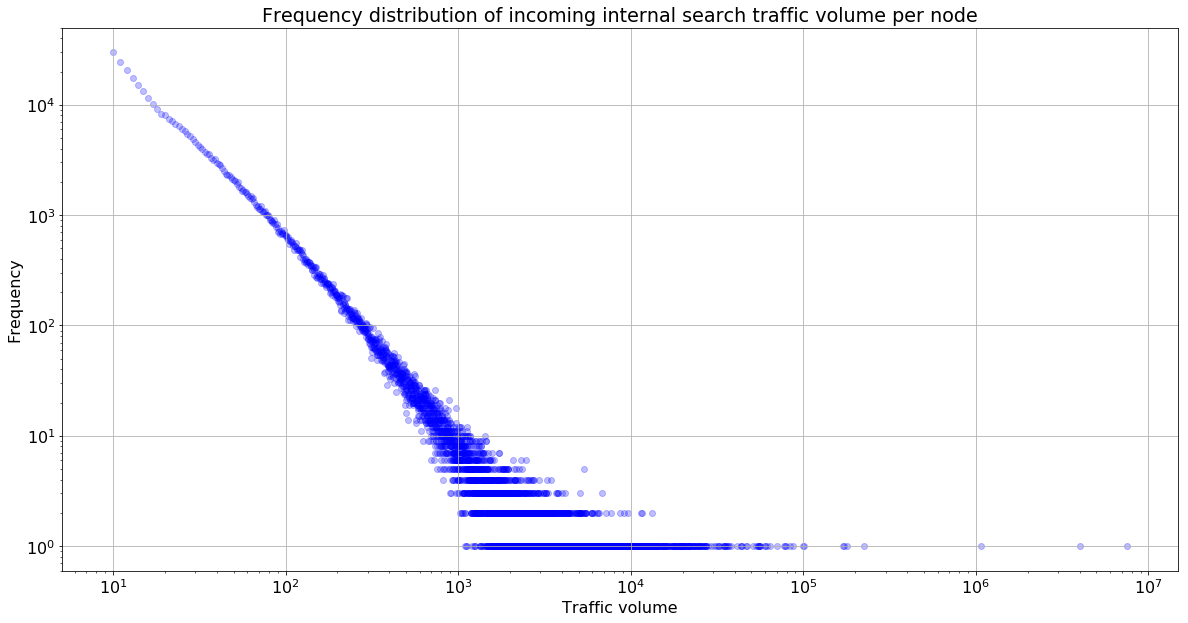

In [185]:
plot_freq_on_log_log_scale(other_end_nodes_traffic_freq, 
                           "Frequency distribution of incoming internal search traffic volume per node")

In [186]:
other_end_nodes.sort_values("edges_count", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
curr,,,,,
Hyphen-minus,127458,7557718,0.1268,0.1259,59.2958
Main_Page,110009,4013760,0.1094,0.0669,36.4857
Aquaman_(film),711,87294,0.0007,0.0015,122.7764
Spider-Man:_Into_the_Spider-Verse,510,61587,0.0005,0.0010,120.7588
2018_in_film,415,38373,0.0004,0.0006,92.4651
Bird_Box_(film),329,44264,0.0003,0.0007,134.5410
Null,288,7813,0.0003,0.0001,27.1285
Bumblebee_(film),284,34584,0.0003,0.0006,121.7746
Lists_of_deaths_by_year,275,1074677,0.0003,0.0179,3907.9164


In [187]:
other_end_nodes_edge_counts_freq = other_end_nodes.edges_count.value_counts()

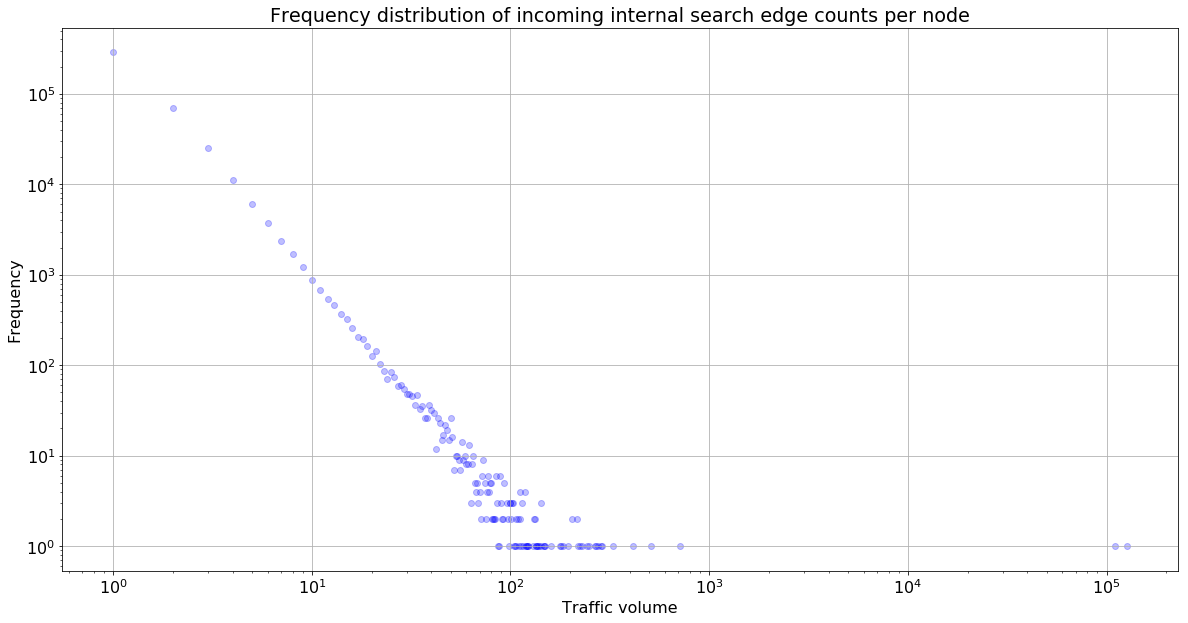

In [188]:
plot_freq_on_log_log_scale(other_end_nodes_edge_counts_freq, 
                           "Frequency distribution of incoming internal search edge counts per node")

In [189]:
other_end_nodes.sort_values("traffic_avg", ascending=False).head(20)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct,traffic_avg
curr,,,,,
Balangiga_bells,2,171835,0.0000,0.0029,85917.5000
OSIRIS-REx,1,78426,0.0000,0.0013,78426.0000
Allied_naval_bombardments_of_Japan_during_World_War_II,1,77714,0.0000,0.0013,77714.0000
Marşandiz_train_collision,1,70717,0.0000,0.0012,70717.0000
Laurence_Olivier,1,60131,0.0000,0.0010,60131.0000
SY_Aurora's_drift,1,56364,0.0000,0.0009,56364.0000
Jean_Baptiste_Point_du_Sable,1,55664,0.0000,0.0009,55664.0000
Enrico_Fermi,1,54749,0.0000,0.0009,54749.0000
Benjamin_Tillman,1,54615,0.0000,0.0009,54615.0000


In [205]:
other_end_nodes_traffic_avg_freq = np.floor(other_end_nodes.traffic_avg).value_counts()

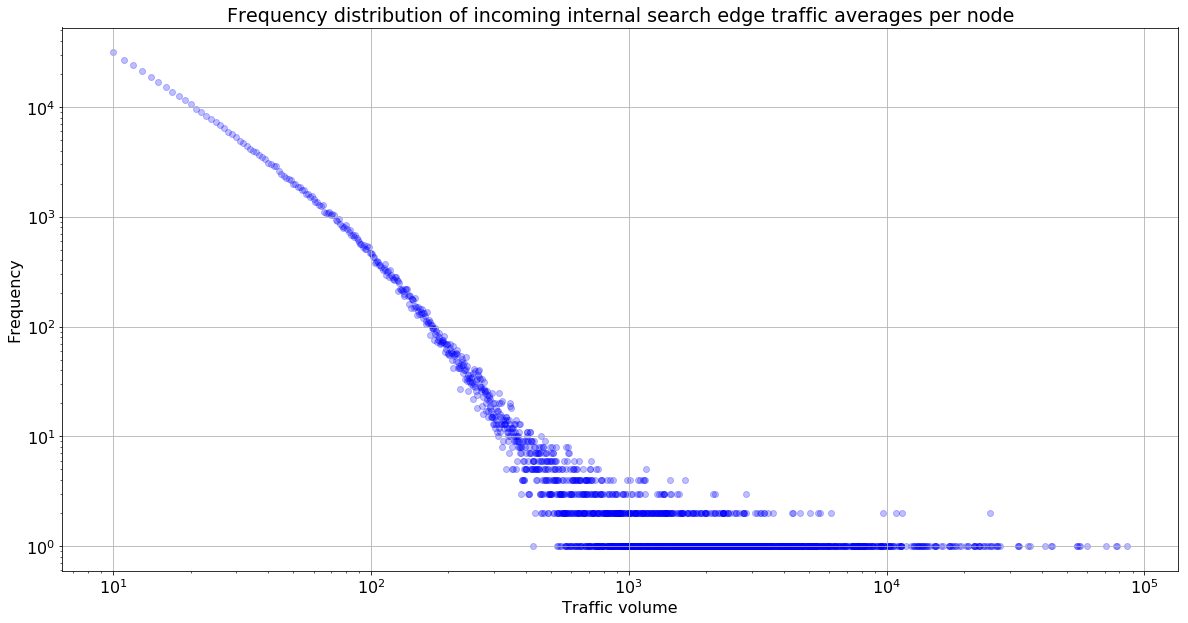

In [206]:
plot_freq_on_log_log_scale(other_end_nodes_traffic_avg_freq, 
                           "Frequency distribution of incoming internal search edge traffic averages per node")

### 4. Summary of findings

### 5. Next steps